<a href="https://colab.research.google.com/github/MamadouBousso/IAProjects/blob/master/classificationbinaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Binaire

In [1]:
import sys

## Charger les fichiers: A executer une seule fois

In [12]:
!cp "/content/drive/MyDrive/Colab Notebooks/BinaryClassifcation/histopathologic-cancer-detection.zip" '.'


In [13]:
!unzip -q histopathologic-cancer-detection.zip


In [14]:
!rm histopathologic-cancer-detection.zip

## Creer les chemins

In [4]:
path_data_train = '/content/train'

In [5]:
path_data_test = '/content/test'

In [6]:
path_data = '/content/'

In [135]:
path2weights = '/content/models'

In [8]:
path_helper = '/content/drive/MyDrive/Colab Notebooks/BinaryClassifcation/histo'

In [11]:
sys.path.append(path_data_train)
sys.path.append(path_data_test)
sys.path.append(path_data)
sys.path.append(path_helper)
sys.path.append(path2weights)

## Visualiser les labels

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

labels = pd.read_csv(path_data+'train_labels.csv')

In [16]:
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


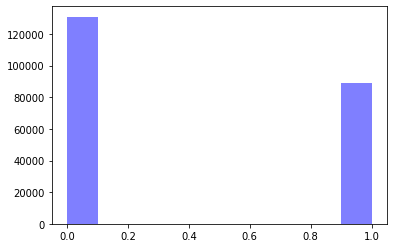

In [17]:
plt.hist(x=labels['label'],  facecolor='blue', alpha=0.5)
plt.show()

## Visualisation des données

In [18]:

from PIL import Image, ImageDraw
import numpy as np
import os
%matplotlib inline

In [19]:
# get ids for malignant images
malignantIds = labels.loc[labels['label']==1]['id'].values

In [20]:
# show images in grayscale, if you want color change it to True
color=True

In [21]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows,ncols=2,2

<Figure size 720x720 with 0 Axes>

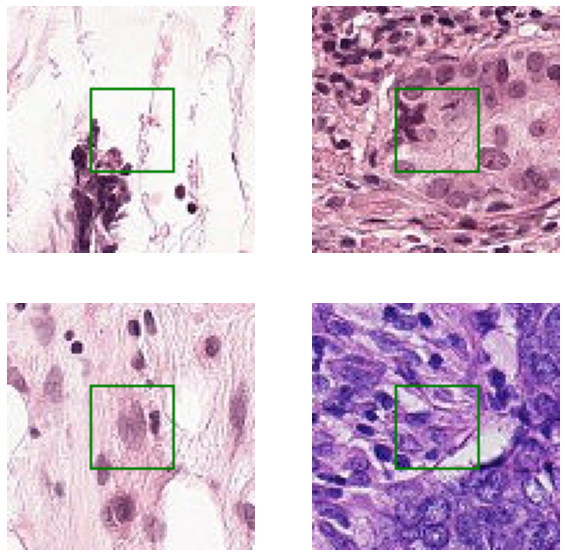

In [22]:
for i,id_ in enumerate(malignantIds[:nrows*ncols]):
  full_filenames = os.path.join(path_data_train  , id_ +'.tif')
  # load image
  img = Image.open(full_filenames)
  # draw a 32*32 rectangle
  draw = ImageDraw.Draw(img)
  draw.rectangle(((32, 32), (64, 64)),outline="green")
  plt.subplot(nrows, ncols, i+1)
  if color is True:
    plt.imshow(np.array(img))
  else:
    plt.imshow(np.array(img)[:,:,0],cmap="gray")
  plt.axis('off')

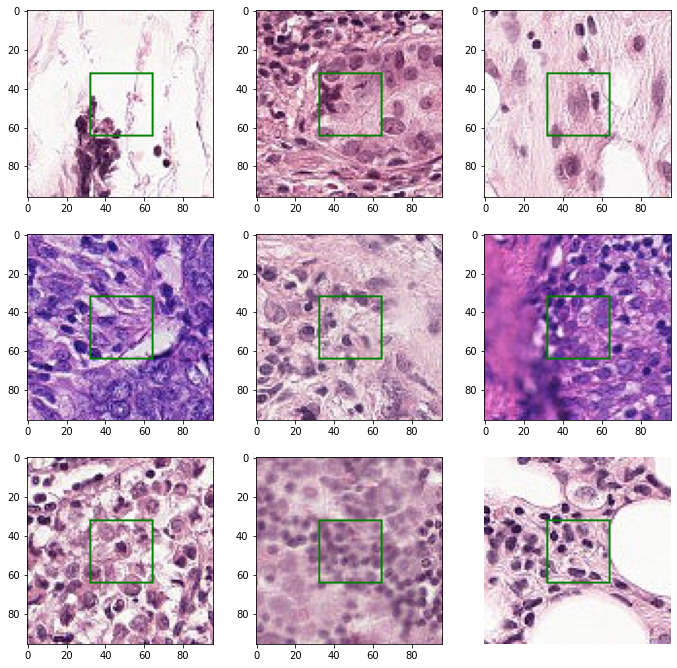

In [23]:
import helper_fonction
helper_fonction.visualiser(path_data_train,malignantIds,3,3,True,0,0)

In [24]:
print("forme de l'image ",np.array(img).shape)
print("Taille des pixels de l'image ",np.min(np.array(img)),np.max(np.array(img)))

forme de l'image  (96, 96, 3)
Taille des pixels de l'image  0 255


## Creer un dataset

Une méthode traditionnelle pour travailler avec un ensemble de données serait de charger toutes les images dans des tableaux NumPy. Étant donné que nous avons affaire à un ensemble de données relativement volumineux, ce serait un gaspillage de ressources informatiques. Si vous manquez de RAM, ce serait impossible. Heureusement, PyTorch
dispose d'un outil puissant pour gérer de grands ensembles de données.
Nous pouvons créer une classe Dataset personnalisée en sous-classant la classe PyTorch Dataset. Lorsque
vous créez une classe Dataset personnalisée, assurez-vous de définir deux fonctions essentielles : ‘__len__‘ et
’__getitem__’. La fonction __len__ renvoie la longueur de l'ensemble de données. Cette fonction est appelable
avec la fonction Python **len**. La fonction __getitem__ renvoie une image correspondant à un
indice donné.

### Comment proceder ?
Nous allons définir une classe personnalisé pour l'ensemble de données, définir la fonction de transformation, puis
charger une image à partir de l'ensemble de données à l'aide de la classe **Dataset**. Commençons:

In [25]:
# fix torch random seed

import torch
from torch.utils.data import Dataset

import torchvision.transforms as transforms

torch.manual_seed(0)

In [26]:
class HistoDataset(Dataset):
  def __init__(self,path_data,transform,data_type ="train"):
    
    #Obtenir le path des données d'image
    path2data = os.path.join(path_data,data_type)
    # Obtenir une liste de données
    full_filenames = os.listdir(path2data)
    # Obtenir les chemins vers les images
    self.full_files = [os.path.join(path2data,f) for f in full_filenames]
    # Les labels sont dans un fichier csv denommé train_labels.csv
    
    label_frame = pd.read_csv(path_data+'train_labels.csv')
    # Mettre l'index du data frame à id
    idx = label_frame.set_index("id",inplace = True)
    # obtenir les labels du data frame
    self.labels = [label_frame.loc[filename[:-4]]['label'] for filename in full_filenames]

    self.transform = transform
   


  def __len__(self):
    return len(self.full_files)

  def __getitem__(self,i):
    '''
    Ouvre  l'image numero i, applique le transform et retourne avec le label
    '''
    img = Image.open(self.full_files[i])
    img = self.transform(img)
    return img,self.labels[i]
    

In [27]:
# Appliquer une pile de transformation, pour le moment juste transformer les images en tenseurs
transform = transforms.Compose([
     
    transforms.ToTensor(),
])


In [28]:
thedata = HistoDataset(path_data,transform)

In [29]:
print(len(thedata))

220025


In [30]:
img, label = thedata[10]

In [31]:
print(label)

1


In [32]:
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


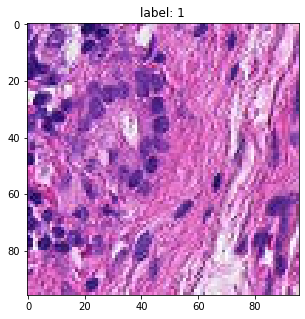

In [33]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
helper_fonction.show(img,label,True)

## Decoupage du Dataset
On utilise random_split() de torch.data.utils

In [34]:
from torch.utils.data import random_split
len_data=len(thedata)
len_train=int(0.8*len_data)
len_val=len_data-len_train
train_ds,val_ds=random_split(thedata,[len_train,len_val])
print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


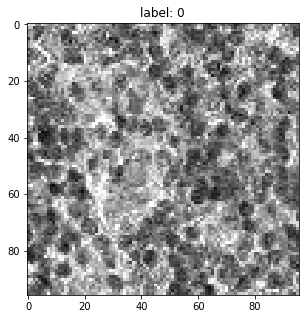

In [35]:
for x,y in train_ds:
  helper_fonction.show(x,y)
  
  break

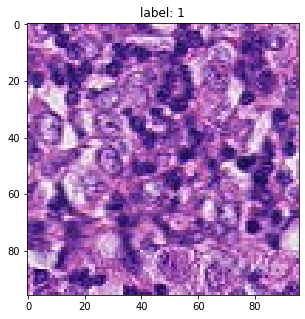

In [36]:
for x,y in val_ds:
  helper_fonction.show(x,y,True)
  break

## Transformer les données
Les transformations typiques incluent
retournement, rotation et redimensionnement horizontal et vertical. Nous pouvons utiliser
diverses transformations d'images pour notre modèle de classification binaire sans changer les étiquettes. Par exemple, si nous tournons ou retournons une image maligne, elle restera maligne. 

In [37]:
train_transformer = transforms.Compose([
transforms.RandomHorizontalFlip(p=0.5),
transforms.RandomVerticalFlip(p=0.5),
transforms.RandomRotation(45),
transforms.RandomResizedCrop(96,scale=(0.8,1.0),ratio=(1.0,1.0)),
transforms.ToTensor()])

**Pour les images de validation on transforme seulement les données en tenseurs** 

In [38]:
val_transformer = transforms.Compose([transforms.ToTensor()])

In [39]:
train_ds.transform = train_transformer

In [40]:
val_ds.transform = val_transformer

## Dataloader

In [41]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=True)

In [42]:
x,y = next(iter(train_dataloader))
print(x.shape)
print(y.shape)

torch.Size([64, 3, 96, 96])
torch.Size([64])


# Creer un modele

## Creer un baseline

In [43]:
# recuperer les labels des donnees
y_val = [y for _,y in val_ds]

In [45]:
def accuracy(labels,out):
  return np.sum(labels==out)/float(len(labels))

In [46]:
# accuracy pour toutes les zeros prédits
acc_all_zeros=accuracy(y_val,np.zeros_like(y_val))
print("accuracy all zero prediction: %.2f" %acc_all_zeros)

accuracy all zero prediction: 0.59


In [47]:
#accuracy all ones predictions
acc_all_ones=accuracy(y_val,np.ones_like(y_val))
print("accuracy all one prediction: %.2f" %acc_all_ones)

accuracy all one prediction: 0.41


In [48]:
# accuracy predictions aletoires
acc_random=accuracy(y_val,np.random.randint(2,size=len(y_val)))
print("accuracy random prediction: %.2f" %acc_random)

accuracy random prediction: 0.50


## Creer un modéle

In [49]:
import torch.nn as nn
import numpy as np

In [50]:
# Permet de calculer les coordonnées de sortie pour chaque couche

def findConv2dOutShape(H_in,W_in,conv,pool=2):
  # get conv arguments
  kernel_size=conv.kernel_size
  stride=conv.stride
  padding=conv.padding
  dilation=conv.dilation

  H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
  W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
  if pool:
    H_out/=pool
    W_out/=pool
  return int(H_out),int(W_out)

In [51]:
# exemple
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h,w=findConv2dOutShape(96,96,conv1)
print(h,w)

47 47


In [97]:
import torch.nn.functional as F
class Model(nn.Module):
  def __init__(self,initial_params):
    super(Model, self).__init__()
    C_in,H_in,W_in = initial_params['input_shape']
    init_f=initial_params["initial_filters"]
    num_fc1=initial_params["num_fc1"]
    num_classes=initial_params["num_classes"]
    self.dropout_rate=initial_params["dropout_rate"]
    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
    h,w=findConv2dOutShape(H_in,W_in,self.conv1)
    self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
    h,w=findConv2dOutShape(h,w,self.conv2)
    self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
    h,w=findConv2dOutShape(h,w,self.conv3)
    self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
    h,w=findConv2dOutShape(h,w,self.conv4)
    # compute the flatten size
    self.num_flatten=h*w*8*init_f
    self.fc1 = nn.Linear(self.num_flatten, num_fc1)
    self.fc2 = nn.Linear(num_fc1, num_classes)
    
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, self.num_flatten)
    x = F.relu(self.fc1(x))
    x=F.dropout(x, self.dropout_rate, training= self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [115]:
initial_parameters={'input_shape':(3,96,96),"initial_filters":8,"num_fc1":100,"num_classes":2,"dropout_rate":0.25}

In [116]:
mod = Model(initial_parameters)

**Remarque**
Nous avons  ajouté une couche de dropout avant la couche de sortie pour réduire le problème de surapprentissage. Notez que nous définissons l'argument **training = self.training** dans
la fonction F.dropout. Le paramètre **self.training** est automatiquement défini sur **True**
pendant la formation et **False** à l'évaluation. Cela contournera la couche de dropout au
temps de déploiement.
La couche de dropout n'est appliquée que pendant l'entraînement. Au déploiement, elle doit être désactivée. Pour ce faire, assurez-vous de définir l'argument **training**
 de la couche de dropout sur **False** au déploiement.

**Mettre le modele sous CUDA**

In [117]:
# move model to cuda/gpu device
if torch.cuda.is_available():
  device = torch.device("cuda")
  mod=mod.to(device)

**Summary du modéle**

In [118]:
from torchsummary import summary
summary(mod,input_size=(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.92
Params size (MB): 0.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


## Definition de la fonction perte
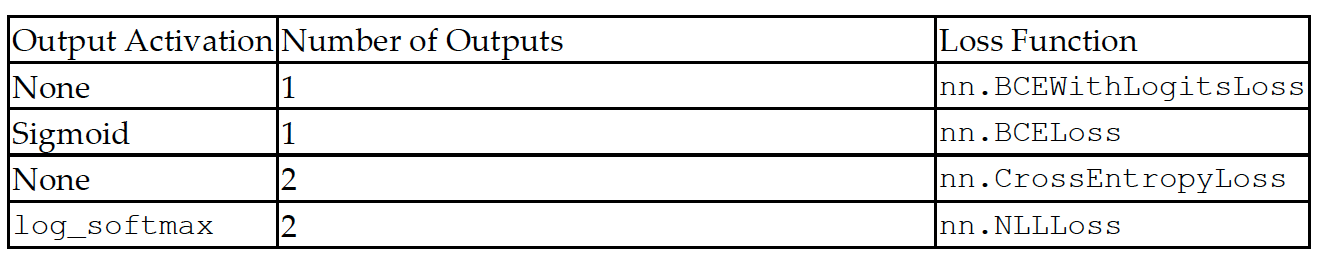

In [119]:
loss_func = nn.NLLLoss(reduction="sum")

**Exemple**

In [58]:
# fix random seed
torch.manual_seed(0)
n,c=8,2
y = torch.randn(n, c, requires_grad=True)
ls_F = nn.LogSoftmax(dim=1)
y_out=ls_F(y)
print(y_out.shape)
target = torch.randint(c,size=(n,))
print(target.shape)
loss = loss_func(y_out, target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8])
5.266995429992676


In [59]:
loss.backward()
print (y.data)

tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


**Remarque**
**log_softmax** est utilisé comme sortie et **nn.NLLLoss** comme la perte negative de la log-vraisemblance. Un argument important dans la définition de la fonction de perte à laquelle il faut prêter attention est la
réduction, qui spécifie la réduction à appliquer à la sortie. Il y a trois options: aucune, somme et moyenne. Nous choisissons **réduction=somme** pour que la perte de sortie soit
additionné. Étant donné que nous traiterons les données par lots, cela renverra la somme des 
valeurs des pertes par lot de données.
À l'étape 2, nous calculons la perte à l'aide d'un exemple avec n=8 échantillons et c=2 classes.
À l'étape 3, nous calculons les gradients pour l'exemple de l'étape 2. Plus tard, nous utiliserons le
méthode à rebours pour calculer les gradients de la perte par rapport au modèle
paramètres.

**Optimiseur**
Objectif: définir un optimiseur, obtenir le taux d'apprentissage actuel et
définir un planificateur d'apprentissage.

In [120]:
from torch import optim
opt = optim.Adam(mod.parameters(), lr=3e-4)

**Learning rate**

In [61]:
# Obtenir le learning rate
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']
current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))


current lr=0.0003


**Planificateur d'apprentissage**
Ensuite, nous allons définir un planificateur d'apprentissage en utilisant la methode  **ReduceLROnPlateau**:
Permet de reduire le learning rate quand le loss atteint un plateau
[voir ce lien](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/)

In [62]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5,patience=20,verbose=1)

In [63]:
#Exemple
for i in range(100):
  lr_scheduler.step(1)

Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.
Epoch    64: reducing learning rate of group 0 to 3.7500e-05.
Epoch    85: reducing learning rate of group 0 to 1.8750e-05.


## Training

In [121]:
#Tout d'abord, développons une help fonction pour compter le nombre de prédictions correctes par lot de données :
def metrics_batch(output, target):
  # get output class
  pred = output.argmax(dim=1, keepdim=True)
  # compare output class with target class
  corrects=pred.eq(target.view_as(pred)).sum().item()
  return corrects

In [122]:
# Ensuite, nous développerons une help fonction  pour calculer la valeur de perte par lot de données :
def loss_batch(loss_func, output, target, opt=None):
  loss = loss_func(output, target)
  with torch.no_grad():
    metric_b = metrics_batch(output,target)
  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()
  return loss.item(), metric_b

Ensuite, nous développons une help fonction  pour calculer la valeur de perte et le
métrique de performance pour l'ensemble de données, également appelée époque.

In [123]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
  running_loss=0.0
  running_metric=0.0
  len_data=len(dataset_dl.dataset)
  for xb, yb in dataset_dl:
    # move batch to device
    if torch.cuda.is_available():
      xb=xb.to("cuda")
      yb=yb.to("cuda")
    # get model output
    output=model(xb)
    # get loss per batch
    loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
      # update running loss
    running_loss+=loss_b
      # update running metric
    if metric_b is not None:
      running_metric+=metric_b
        # break the loop in case of sanity check
    if sanity_check is True:
      break
#  average loss value
  loss=running_loss/float(len_data)
    # average metric value
  metric=running_metric/float(len_data)
  return loss, metric

In [124]:
def train_val(model, params):
  # extract model parameters
  num_epochs=params["num_epochs"]
  loss_func=params["loss_func"]
  opt=params["optimizer"]
  train_dl=params["train_dl"]
  val_dl=params["val_dl"]
  sanity_check=params["sanity_check"]
  lr_scheduler=params["lr_scheduler"]
  path2weights=params["path2weights"]
  # history of loss values in each epoch
  loss_history={"train": [],"val": [],}
  # history of metric values in each epoch
  metric_history={"train": [],"val": [],}
  # a deep copy of weights for the best performing model
  best_model_wts = copy.deepcopy(model.state_dict())
  # initialize best loss to a large value
  best_loss=float('inf')

  # main loop
  for epoch in range(num_epochs):
    # get current learning rate
    current_lr=get_lr(opt)
    print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs- 1, current_lr))
    # train model on training dataset
    model.train()
    train_loss,train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
    # collect loss and metric for training dataset
    loss_history["train"].append(train_loss)
    metric_history["train"].append(train_metric)

    # evaluate model on validation dataset
    model.eval()
    with torch.no_grad():
      val_loss,val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
      # collect loss and metric for validation dataset
      loss_history["val"].append(val_loss)
      metric_history["val"].append(val_metric)
    # store best model
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      # store weights into a local file
      torch.save(model.state_dict(), path2weights)
      print("Copied best model weights!")
    # learning rate schedule
    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
      print("Loading best model weights!")
      model.load_state_dict(best_model_wts)
    print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f"%(train_loss,val_loss,100*val_metric))
    print("-"*10)
  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, loss_history, metric_history

In [125]:
#Definition des objets pour l'optimization, le loss, et la planification du learning rate
import copy
loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(mod.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.2,patience=2,verbose=1)

In [136]:
weights_file = ''
weights_file = os.path.join(path2weights  , 'weights.pt')
print(weights_file)

/content/models/weights.pt


In [137]:
#Definition des paramétres d'apprentissage et appel de la helper fonction train_val
params_train={
"num_epochs": 4,
"optimizer": opt,
"loss_func": loss_func,
"train_dl": train_dataloader,
"val_dl": val_dataloader,
"sanity_check": False,
"lr_scheduler": lr_scheduler,
"path2weights": weights_file,
}

In [138]:
# train and validate the model

mod,loss_hist,metric_hist=train_val(mod,params_train)

Epoch 0/3, current lr=0.0003
Copied best model weights!
train loss: 0.336525, dev loss: 0.337508, accuracy: 85.10
----------
Epoch 1/3, current lr=0.0003
Copied best model weights!
train loss: 0.317912, dev loss: 0.316162, accuracy: 86.50
----------
Epoch 2/3, current lr=0.0003
Copied best model weights!
train loss: 0.302958, dev loss: 0.287291, accuracy: 88.10
----------
Epoch 3/3, current lr=0.0003
Copied best model weights!
train loss: 0.289358, dev loss: 0.281192, accuracy: 88.37
----------


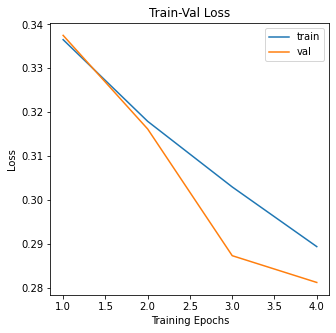

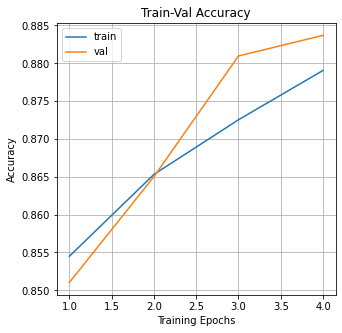

In [139]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]
# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid()
plt.show()

Il y a plus...
Une fois que vous obtenez une performance de base en utilisant votre premier modèle, vous pouvez commencer à régler les
hyperparamètres. Le réglage des hyperparamètres est une technique utilisée pour améliorer les performances du modèle. Un moyen efficace de le faire est d'utiliser une recherche aléatoire. Nous avons défini les
hyperparamètres en tant que variables afin que vous puissiez facilement jouer avec eux. Essayez différentes valeurs pour
les hyperparamètres et voir comment les performances du modèle sont affectées. A titre d'exemple, essayez
augmenter le nombre de filtres CNN en définissant initial_filters = 16 et en recyclant
le modèle.

## Deploiement du modele
Nous supposons que vous souhaitez déployer le modèle pour l'inférence dans un nouveau script distinct à partir des scripts de training et dans ce cas, le modèle et les poids n'existent pas en mémoire.
Par conséquent, nous devons construire un objet de la classe **model** et charger les poids dans cet objet.



1.   Tout d'abord, nous allons créer un objet de la classe model et charger les poids stockés dans le modéle:




In [144]:
# model parameters
params_model={
"input_shape": (3,96,96),
"initial_filters": 8,
"num_fc1": 100,
"dropout_rate": 0.25,
"num_classes": 2,
}
# initialize model
cnn_model = Model(params_model)




2.   Chargeons le state_dict dans le modéle



In [145]:
# load state_dict into model
path2weights="./models/weights.pt"
cnn_model.load_state_dict(torch.load(path2weights))

<All keys matched successfully>




3. Mettre le modéle en mode evaluation



In [146]:
# set model in evaluation mode
cnn_model.eval()

Model(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [147]:
# mettre le modele dans un device cuda/gpu
if torch.cuda.is_available():
  device = torch.device("cuda")
  cnn_model=cnn_model.to(device)

**Deployer le modéle dans un dataset**

1. À l'étape 1, nous avons construit un objet de la classe modèle. N'oubliez pas de copier la classe **Model** et
les scripts de fonction findConv2dOutShape dans votre nouveau script. Lorsque nous construisons un
objet de la classe **Model**, les poids sont initialisés aléatoirement.
2. À l'étape 2, nous avons chargé state_dict, qui contient les poids du modèle, dans le modèle. Pour un
déploiement, il est nécessaire de mettre le modèle en mode eval. Ceci est important car certains
les couches (telles que dropout) fonctionnent différemment dans les modes de training et de déploiement. Si un CUDA
 est disponible, nous devons déplacer le modèle dessus. Maintenant, le modèle est prêt à être
déployé.
3. À l'étape 5, la helper fonction renvoient les sorties du modèle et les vrais labels sous la forme NumPy
tableaux pour l'ensemble de données. En outre, le temps d'inférence par image sur  CUDA est estimé
être de 0,74 ms. Plus tard, nous verrons le temps d'inférence sur le périphérique CPU.
4. À l'étape 6, nous vérifions le modèle stocké en le déployant sur le jeu de données de validation. Beaucoup de
choses pourraient mal tourner lors du développement de modèles. Nous recommandons de
vérifier les performances du modèle stocké en déployant le modèle sur un jeu de données connu, par exemple, l'ensemble de données de validation.
5. À l'étape 7, nous utilisons le package scikit-learn pour calculer la précision de notre 
modèle de classement binaire. Vous pouvez installer le package en utilisant le code suivant :

In [148]:
def deploy_model(model,dataset,device,num_classes=2,sanity_check=False):
  len_data=len(dataset)
  # initialize output tensor on CPU: due to GPU memory limits
  y_out=torch.zeros(len_data,num_classes)
  # initialize ground truth on CPU: due to GPU memory limits
  y_gt=np.zeros((len_data),dtype="uint8")
  # move model to device
  model=model.to(device)
  elapsed_times=[]
  with torch.no_grad():
    for i in range(len_data):
      x,y=dataset[i]
      y_gt[i]=y
      start=time.time()
      y_out[i]=model(x.unsqueeze(0).to(device))
      elapsed=time.time()-start
      elapsed_times.append(elapsed)
      if sanity_check is True:
        break
  inference_time=np.mean(elapsed_times)*1000
  print("average inference time per image on %s: %.2f ms "%(device,inference_time))
  return y_out.numpy(),y_gt

**Utilisons cette fonction dans les données de validation**

In [149]:
# deploy model
import time
y_out,y_gt=deploy_model(cnn_model,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cuda: 0.91 ms 
(44005, 2) (44005,)


**Calculons la précision du modèle sur l'ensemble de données de validation en utilisant les
sorties prévues :**

In [150]:
from sklearn.metrics import accuracy_score
# get predictions
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)
# compute accuracy
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f" %acc)

(44005,) (44005,)
accuracy: 0.88


## Inference du modéle sur les données de test
Semblable aux données de validation, nous pouvons déployer le modèle sur l'ensemble de données de test. Les étiquettes pour
l'ensemble de données de test ne sont pas disponibles. Par conséquent, nous ne pourrons pas évaluer le modèle
performances sur l'ensemble de données de test.

1. Creer un dataset avec les données de test

2. Deployer le modéle sur les données de test

3. Visualiser des données avec les labels predits

4. Faire un fichier de soumission